<a href="https://colab.research.google.com/github/lipecamara/portifolio/blob/main/previsao_bitcoin_com_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf

bitcoin = yf.download('BTC-USD')
bitcoin = bitcoin.stack(level=1)
bitcoin = bitcoin.reset_index().rename(columns={"Ticker": "Ativo"})
bitcoin = bitcoin[["Date", "Open", "High", "Low", "Close", "Ativo"]]
bitcoin.set_index('Date', inplace=True)
bitcoin

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-84a42b3bacf2>:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  bitcoin = bitcoin.stack(level=1)


Price,Open,High,Low,Close,Ativo
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,BTC-USD
2014-09-18,456.859985,456.859985,413.104004,424.440002,BTC-USD
2014-09-19,424.102997,427.834991,384.532013,394.795990,BTC-USD
2014-09-20,394.673004,423.295990,389.882996,408.903992,BTC-USD
2014-09-21,408.084991,412.425995,393.181000,398.821014,BTC-USD
...,...,...,...,...,...
2025-04-15,84539.695312,86429.351562,83598.820312,83668.992188,BTC-USD
2025-04-16,83674.507812,85428.281250,83100.617188,84033.867188,BTC-USD
2025-04-17,84030.671875,85449.070312,83749.750000,84895.750000,BTC-USD


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime

warnings.filterwarnings('ignore')

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

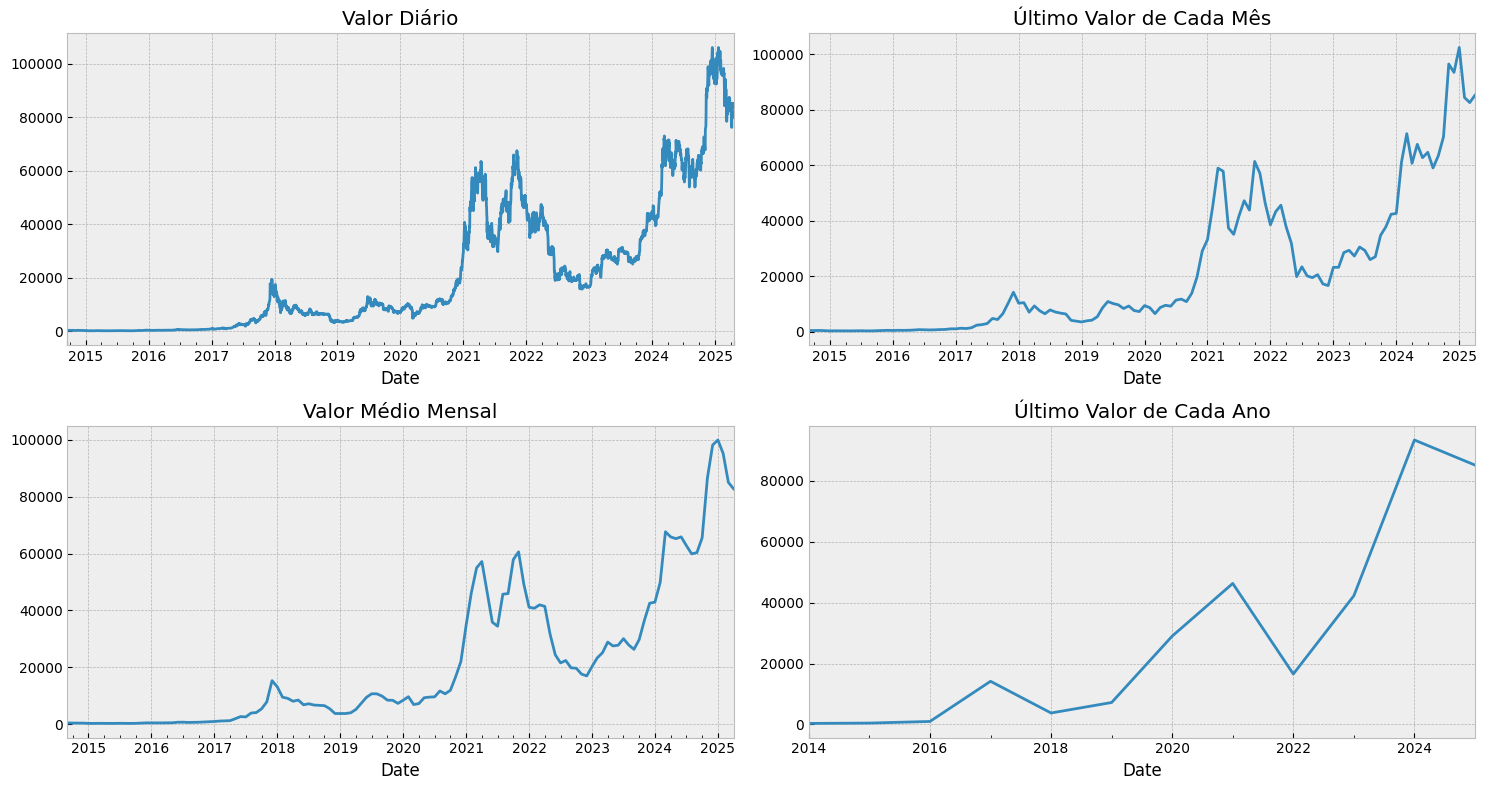

In [ ]:
plt.style.use('bmh')

fig, axs = plt.subplots(2, 2, figsize=(15,8))

bitcoin['Close'].plot(ax = axs[0,0], title = 'Valor Diário')

bitcoin['Close'].resample('ME').last().plot(ax = axs[0,1], title = 'Último Valor de Cada Mês')

bitcoin['Close'].resample('ME').mean().plot(title = 'Valor Médio Mensal', ax = axs[1,0])

bitcoin['Close'].resample('A-DEC').last().plot(ax = axs[1,1], title = 'Último Valor de Cada Ano')

plt.tight_layout()
plt.show()

In [ ]:
btc_mensal = bitcoin[['Close']].resample('ME').mean()

In [ ]:
btc_mensal.columns = ['Preco']

Dickey–Fuller test: p=0.990165


<Figure size 1200x700 with 0 Axes>

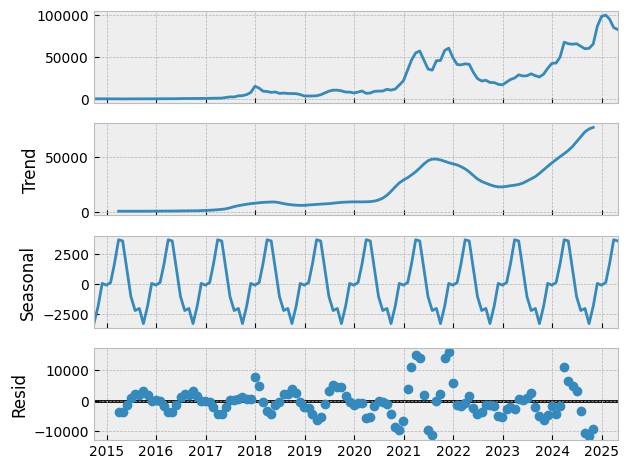

In [ ]:
plt.figure(figsize=(12,7))

sm.tsa.seasonal_decompose(btc_mensal).plot();
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_mensal)[1])
plt.show()

In [ ]:
btc_mensal['Preco_box'], lmbda = stats.boxcox(btc_mensal.Preco)
btc_mensal

,Preco,Preco_box
Date,,
2014-09-30,407.182428,11.188406
2014-10-31,364.148873,10.843977
2014-11-30,366.099799,10.860288
2014-12-31,341.267871,10.647186
2015-01-31,248.782547,9.722455
...,...,...
2024-12-31,98232.948589,41.214739
2025-01-31,99992.847782,41.371184
2025-02-28,95290.709542,40.948038


In [ ]:
btc_mensal['Preco_box_diff'] = btc_mensal['Preco_box'].diff(12)
print(f'{sm.tsa.adfuller(btc_mensal["Preco_box_diff"][12:])[1]}')

0.07760088384665381


In [ ]:
btc_mensal['Preco_box_diff_2'] = btc_mensal['Preco_box_diff'].diff(1)
print(f'{sm.tsa.adfuller(btc_mensal["Preco_box_diff_2"][13:])[1]:.06f}')

0.000036


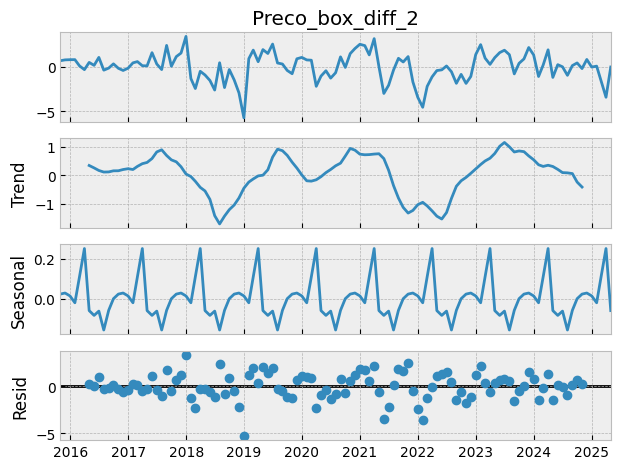

In [ ]:
sm.tsa.seasonal_decompose(btc_mensal['Preco_box_diff_2'][13:]).plot();

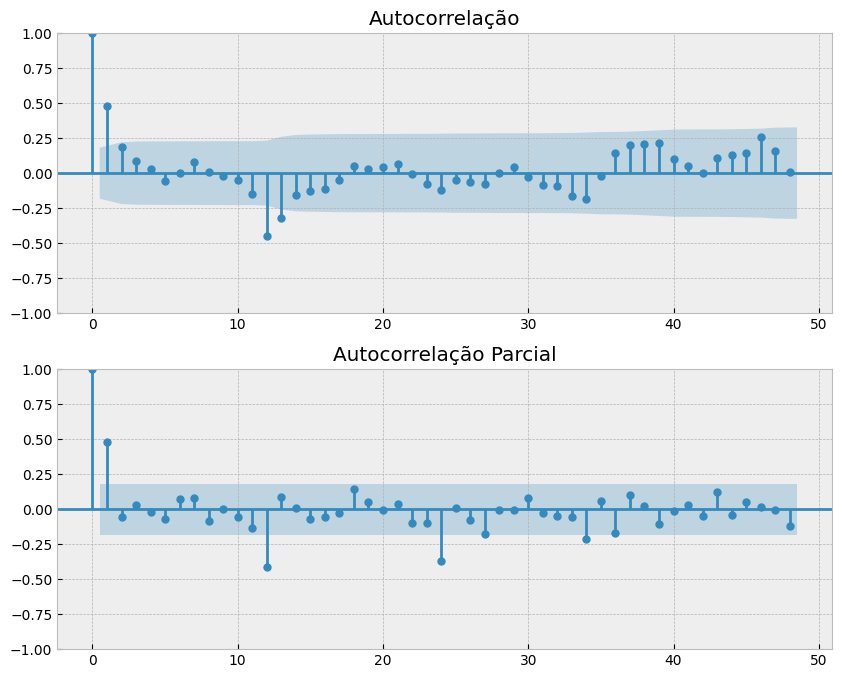

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(btc_mensal['Preco_box_diff_2'][13:], lags=48, ax=ax1, title = 'Autocorrelação')

ax2 = fig.add_subplot(212)
fig = plot_pacf(btc_mensal['Preco_box_diff_2'][13:], lags=48, ax=ax2, title = 'Autocorrelação Parcial')

fig.show()

In [ ]:
# Selecionando o melhor modelo

Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parametros = product(ps, qs, Ps, Qs)
parametros_lista = list(parametros)
len(parametros_lista)

resultados = []
melhor_aic = float("inf")
warnings.filterwarnings('ignore')
for parametro in parametros_lista:
    try:
        modelo = sm.tsa.statespace.SARIMAX(btc_mensal['Preco_box'], order=(parametro[0], d, parametro[1]),
                                        seasonal_order=(parametro[2], D, parametro[3], 12)).fit()
    except ValueError:
        print('wrong parameters:', parametro)
        continue
    aic = modelo.aic
    if aic < melhor_aic:
        melhor_modelo = modelo
        melhor_aic = aic
        melhores_parametros = parametros
    resultados.append([parametro, modelo.aic])

In [ ]:
tabela = pd.DataFrame(resultados)
tabela.columns = ['parametros', 'aic']
print(tabela.sort_values(by = 'aic', ascending=True).head())
print(melhor_modelo.summary())

      parametros         aic
7   (0, 1, 0, 1)  348.884831
19  (1, 0, 0, 1)  349.077264
25  (1, 1, 0, 1)  349.846390
37  (2, 0, 0, 1)  349.972818
13  (0, 2, 0, 1)  350.011312
                                     SARIMAX Results                                      
Dep. Variable:                          Preco_box   No. Observations:                  128
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -171.442
Date:                            Sat, 19 Apr 2025   AIC                            348.885
Time:                                    18:03:47   BIC                            357.120
Sample:                                09-30-2014   HQIC                           352.227
                                     - 04-30-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


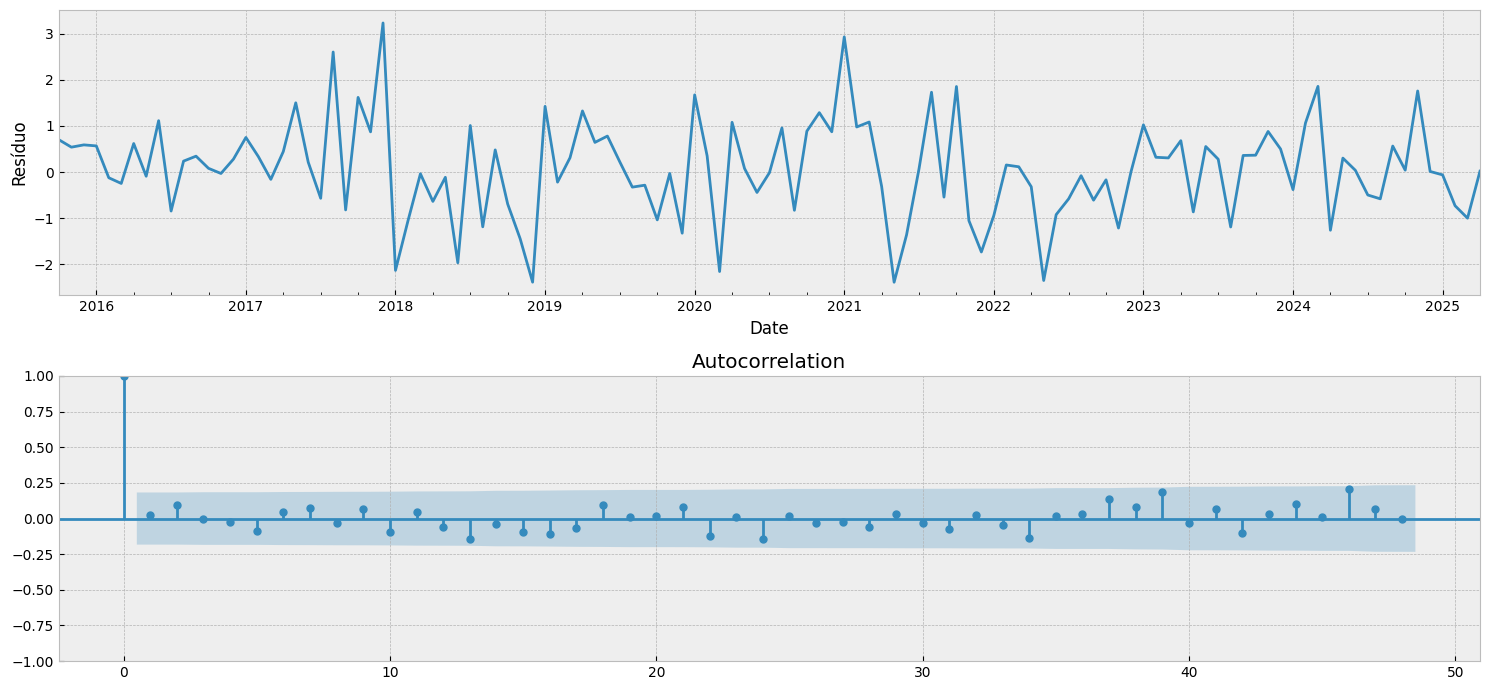

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(211)
melhor_modelo.resid[13:].plot()
plt.ylabel(u'Resíduo')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(melhor_modelo.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(melhor_modelo.resid[13:])[1])

plt.tight_layout()
plt.show()

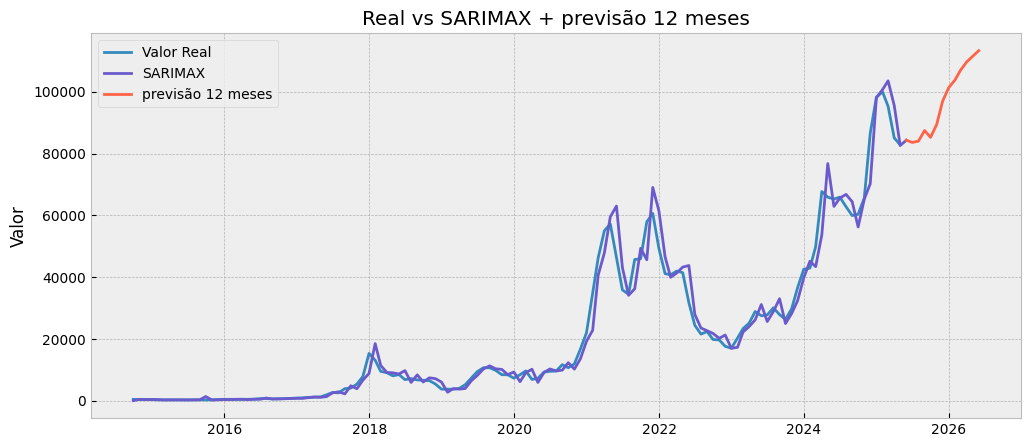

In [ ]:
from scipy.special import inv_boxcox

sarimax = inv_boxcox(melhor_modelo.predict(0, len(btc_mensal)), lmbda)
previsao = inv_boxcox(melhor_modelo.predict(len(btc_mensal), len(btc_mensal) + 12), lmbda)

plt.figure(figsize=(12, 5))

plt.plot(btc_mensal.index, btc_mensal['Preco'].values, label='Valor Real')
plt.plot(sarimax.index, sarimax, label='SARIMAX', color='slateblue')
plt.plot(previsao.index, previsao, label = 'previsão 12 meses', color = 'tomato')
plt.title(f'Real vs SARIMAX + previsão 12 meses')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [ ]:
previsao

,predicted_mean
2025-05-31,84323.391157
2025-06-30,83600.274923
2025-07-31,84037.819181
2025-08-31,87463.966211
2025-09-30,85252.568020
2025-10-31,89435.188077
2025-11-30,96995.074099
2025-12-31,101392.090927
2026-01-31,103805.016918
2026-02-28,106975.843109
